## Validate Gain Flaggin

In [2]:
import matplotlib.pyplot as plt
import os
%matplotlib inline

### Data generation 

We had simulated data using Oskar. The simulation scripts are present in `scripts/ska_low_sim`.

We have simulated measurement set with phase and amplitude corruption.

#### Simulation Configuration for gain flagging

`sim.yaml`

```yaml
scenario: "low40s-model"          # Scenario name (used for output folder prefix)

# ===============================
# Global simulation parameters
# ===============================

n_stations: 40                                         # Number of stations
tel_model: "./telescope-models/SKA-Low_AA2_40S_rigid-rotation_model.tm" # Telescope model directory

simulation_start_frequency_hz: 123.0e6                  # Start frequency (Hz)
simulation_end_frequency_hz: 153.0e6                    # End frequency (Hz)
correlated_channel_bandwidth_hz: 85.70138888888889e3    # Channel width (Hz)

observing_time_mins: 3                              # Observation duration (minutes)
sampling_time_sec: 3.3973862400000003                   # Dump/integration time (seconds)

fields:
  EoR2:
    Cal1:
      ra_deg: 197.914612
      dec_deg: -22.277973
      scan_id_start: 300
      transit_time: "2000-01-03 22:33:30.000"

# ==================================
# Options for generate_gaintable.py
# ==================================

generate_gaintable:
  output_gaintable: &gen_gaintable "./gaintables4/custom_gaintable.h5"

  outlier_config:
    enable: true
    amp_min: 3.0
    amp_max: 7.0
    n_stations_to_corrupt: 5
    n_channels_to_corrupt: 20

  station_offset: true              # Apply per-station amplitude/phase offsets
  time_variant: false                # Apply time-dependent effects

  rfi: false                        # Inject RFI band
  rfi_start_freq_hz: 154.25347222228538e6        # Hz
  rfi_end_freq_hz: 159.8090277778474e6           # Hz

  plot: true                        # Generate diagnostic plots
  plot_output_dir: "./gaintables4/generation_plots/"

# ===============================
# Options for run_sim.py
# ===============================

run_sim:
  oskar_sif: "./OSKAR-2.11.1-Python3.sif" # Path to OSKAR Singularity image

  # GLEAM sky model. Optional. Comment to disable.
  gleam_file: "./sky-models/GLEAM_EGC.fits" # GLEAM catalogue FITS file
  field_radius_deg: 10.0            # Radius of field of view (degrees)

  # Corruptions to be applied. All are optional. Comment to disable.
  gaintable: *gen_gaintable           # Gaintable containing bandpass corruptions
  # cable_delay: "./cable_delays/cable_length_error_40s.txt" # Cable delay error file
  # tec_screen: "./tec/calibrator_iono_tec.fits" # Ionospheric TEC screen FITS

  # Imaging parameters using wsclean. Optional. Comment to disable.
  create_dirty_image: true          # Whether to run wsclean imaging
  image_size: 1024                  # Image size (pixels)
  pixel_size: "2arcsec"             # Pixel size (angular units)

  # Extra parameters to pass directly to utils/run_oskar.py
  run_oskar_extra_params: "--use-gpus --double-precision"
```

First generate the gaintable using the command,

```
python generate_gaintable.py bandpass_delay_sim.yaml
```

Run the simulation.
```
python run_sim.py delay_sim.yaml
```

### Pipeline setup 

In [3]:
cache = "../../cache"
artifacts_prefix_path = "./flag_gain_validation_artefacts"
os.makedirs(artifacts_prefix_path, exist_ok=True)

### With gain outliers

Running the data with bandpass plus gain outliers

In [4]:
input_data = "/home/ska/Work/inst-data-simulation/low40s-model-180226_211802/visibility.scan-300.ms"
gleam_file_path = "/home/ska/Work/data/INST/sim/gleamegc.dat"
flag_gain_artefacts_path = artifacts_prefix_path + "/flag_gain"
os.makedirs(flag_gain_artefacts_path, exist_ok=True)

In [ ]:
## Running the pipeline
!time ska-sdp-instrumental-calibration run \
    --input $input_data \
    --stages "load_data,predict_vis,bandpass_calibration,flag_gain" \
    --set parameters.load_data.cache_directory $cache \
    --set parameters.predict_vis.beam_type "everybeam" \
    --set parameters.predict_vis.normalise_at_beam_centre true \
    --set parameters.predict_vis.gleamfile $gleam_file_path \
    --set parameters.flag_gain.export_gaintable true \
    --set parameters.flag_gain.n_sigma 3.0 \
    --set parameters.flag_gain.plot_config.curve_fit_plot true \
    --set parameters.flag_gain.plot_config.gain_flag_plot true \
    --dask-scheduler "tcp://10.131.131.55:8786" \
    --no-unique-output-subdir \
    --output $flag_gain_artefacts_path

### Comparison and Validation

In our simulated data, we have corrupted these antennas
3, 4, 23, 27, 30


Note: The current behaviour of poly flag is super sensitive to lower RMS value (it will flag a lot when RMS is low [<2.0])

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [6]:
bandpass_gt_path = f"{flag_gain_artefacts_path}/gaintables/bandpass.gaintable.h5parm"
gainflag_gt_path = f"{flag_gain_artefacts_path}/gaintables/gain_flag.gaintable.h5parm"

In [7]:
bandpass_h5 = h5py.File(bandpass_gt_path)
gainflag_h5 = h5py.File(gainflag_gt_path)

In [8]:
bpp_gt = bandpass_h5["sol000"]
fg_gt = gainflag_h5["sol000"]

In [9]:
def plot_gain_comparison(bandpass_sol, flagged_sol, station):
    bp_amp = bandpass_sol["amplitude000"]["val"]
    fg_amp = flagged_sol["amplitude000"]["val"]
    bp_ph = bandpass_sol["phase000"]["val"]
    fg_ph = flagged_sol["phase000"]["val"]

    n_freq = bp_amp.shape[2]
    channels = np.arange(n_freq)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    marker_size = 20

    for pol_idx, pol in [(0, "XX"), (3, "YY")]:
        axes[0, 0].scatter(channels, bp_amp[0, station, :, pol_idx], s=marker_size, label=pol)
        axes[0, 1].scatter(channels, bp_ph[0, station, :, pol_idx], s=marker_size, label=pol)
        axes[1, 0].scatter(channels, fg_amp[0, station, :, pol_idx], s=marker_size, label=pol)
        axes[1, 1].scatter(channels, fg_ph[0, station, :, pol_idx], s=marker_size, label=pol)

    axes[0, 0].set_title("Bandpass Amplitude")
    axes[0, 1].set_title("Bandpass Phase")
    axes[1, 0].set_title("Flagged Amplitude")
    axes[1, 1].set_title("Flagged Phase")

    axes[0, 0].set_ylabel("Amplitude")
    axes[1, 0].set_ylabel("Amplitude")
    axes[0, 1].set_ylabel("Phase (rad)")
    axes[1, 1].set_ylabel("Phase (rad)")
    axes[1, 0].set_xlabel("Channel")
    axes[1, 1].set_xlabel("Channel")

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc=" outside upper right")
    fig.suptitle(f"Station {station} — Gain Flagging Validation", fontsize=14)
    fig.savefig(f"{flag_gain_artefacts_path}/amp-phase-channel-{station}.png")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

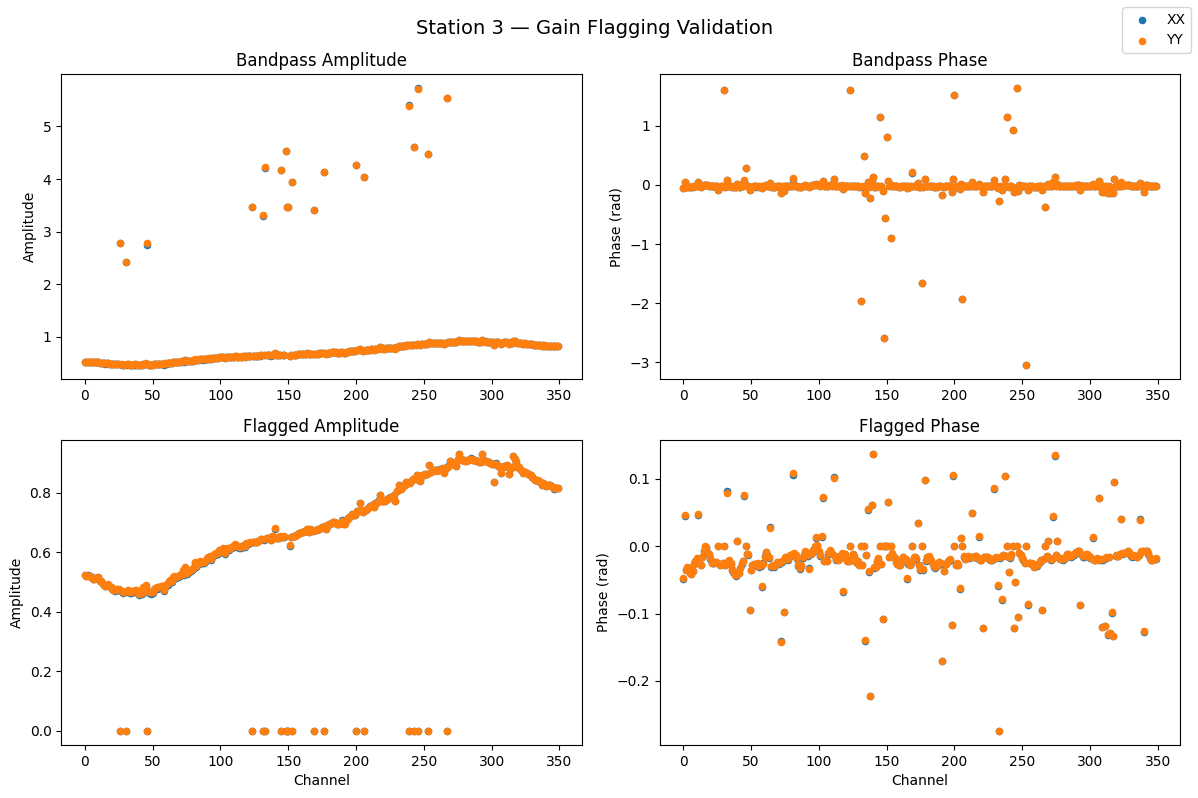

In [10]:
plot_gain_comparison(bpp_gt,fg_gt, 3)